In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from scipy import stats

# Mini-Project 1: Predicting Red Wine Quality with KNN, Decision Trees, Ensembles, and SVM

The purpose of this project is to apply machine learning techniques we have learned in class on a real dataset. The dataset I will be using is titled "winequality-red.csv", and is sourced from the UCI Machine Learning Repository and is also available on Kaggle. This dataset is primarily used for analyzing and predicting red wine quality. It was originally collected for a study by P. Cortez, A. Cerdeira, F. Almeida, T. Matos, and J. Reis in 2009 and has since been widely used by the machine learning community for educational and research purposes. The problem at hand is to predict the quality of red wine based on various physicochemical properties. The dataset comprises 12 features: fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol, and quality. Among these, fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, density, pH, sulphates, and alcohol are continuous numeric features. Free sulfur dioxide and total sulfur dioxide are discrete numeric features representing the amount of sulfur dioxide (in mg/L) that is free and total respectively. The quality is an ordinal variable scored on a scale, usually from 0 to 10 (although the maximum value in this dataset is 8), representing the subjective quality of the wine based on sensory data. The primary objective is to build a predictive model using machine learning techniques that can effectively map the physicochemical properties to the wine quality.

We will first attempt to predict wine quality using a K-nearest-neighbors approach.

## Exploratory Data Analysis

We initially read in the dataset, and add a 'label' column that we will use as a measure of if a wine is of 'good' quality or not - the criteria will be if the wine has a quality rating of 6 or above. We also generate histograms of each feature to examine feature scaling, as KNN can be sensitive to the scales of the features. Additionally, we generate scatterplots of each predictor variable with the 'quality' response variable, and also boxplots of each predictor variable - both of these methods will help us examine for outliers. 

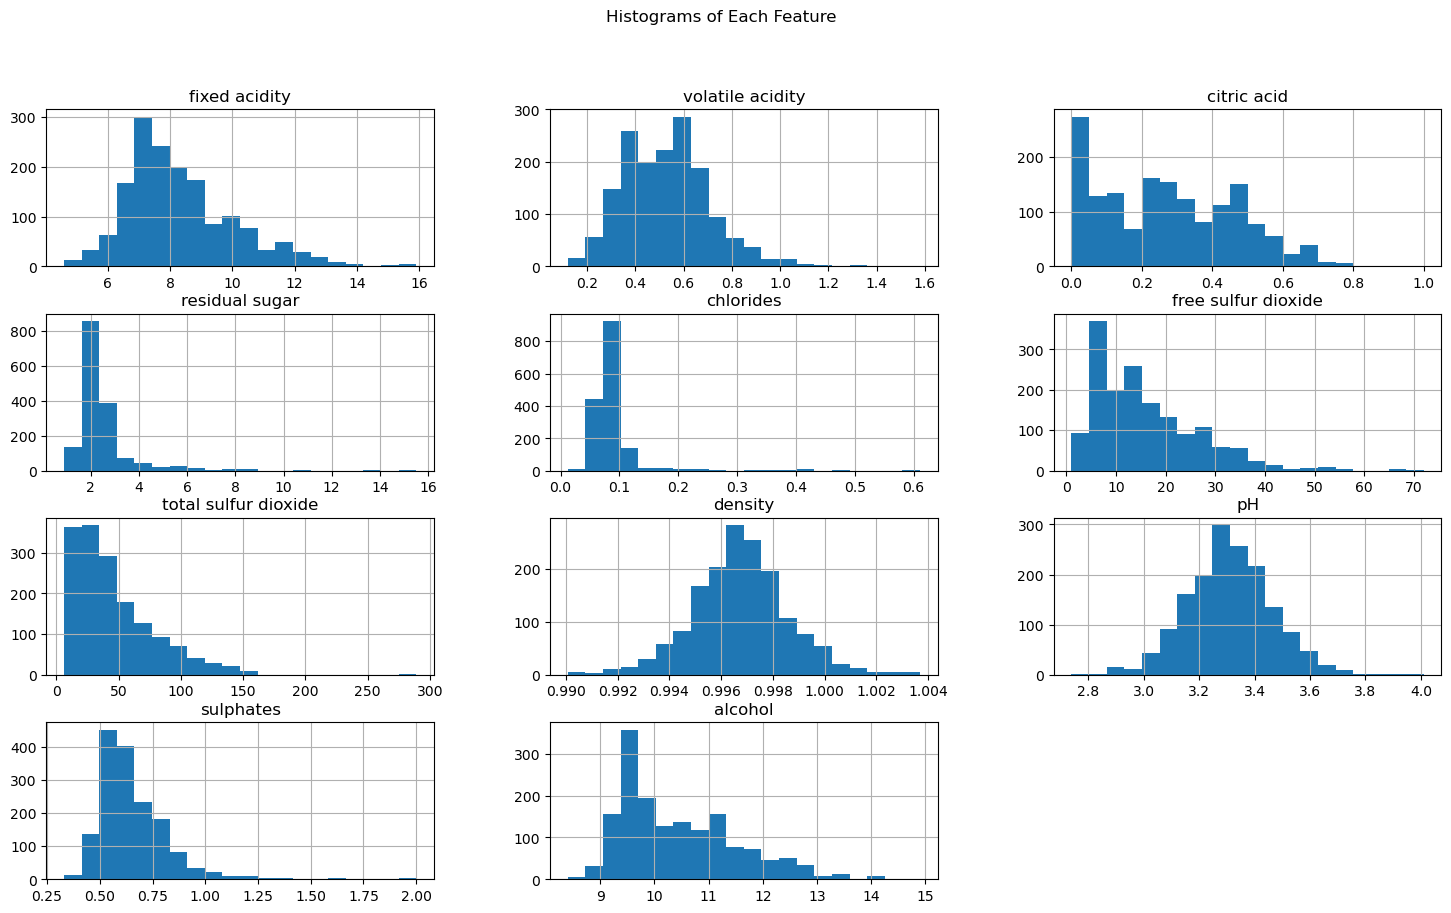

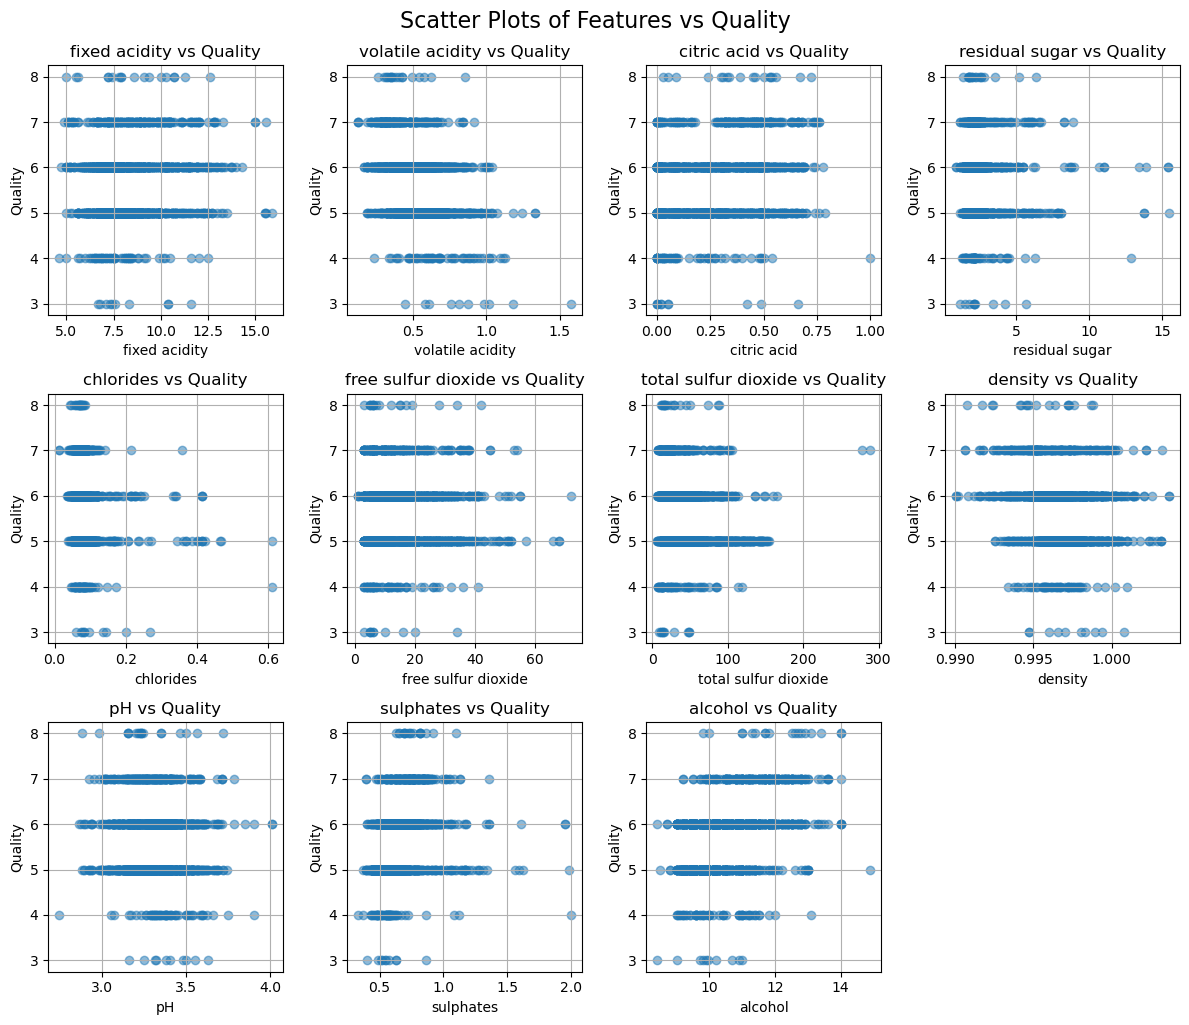

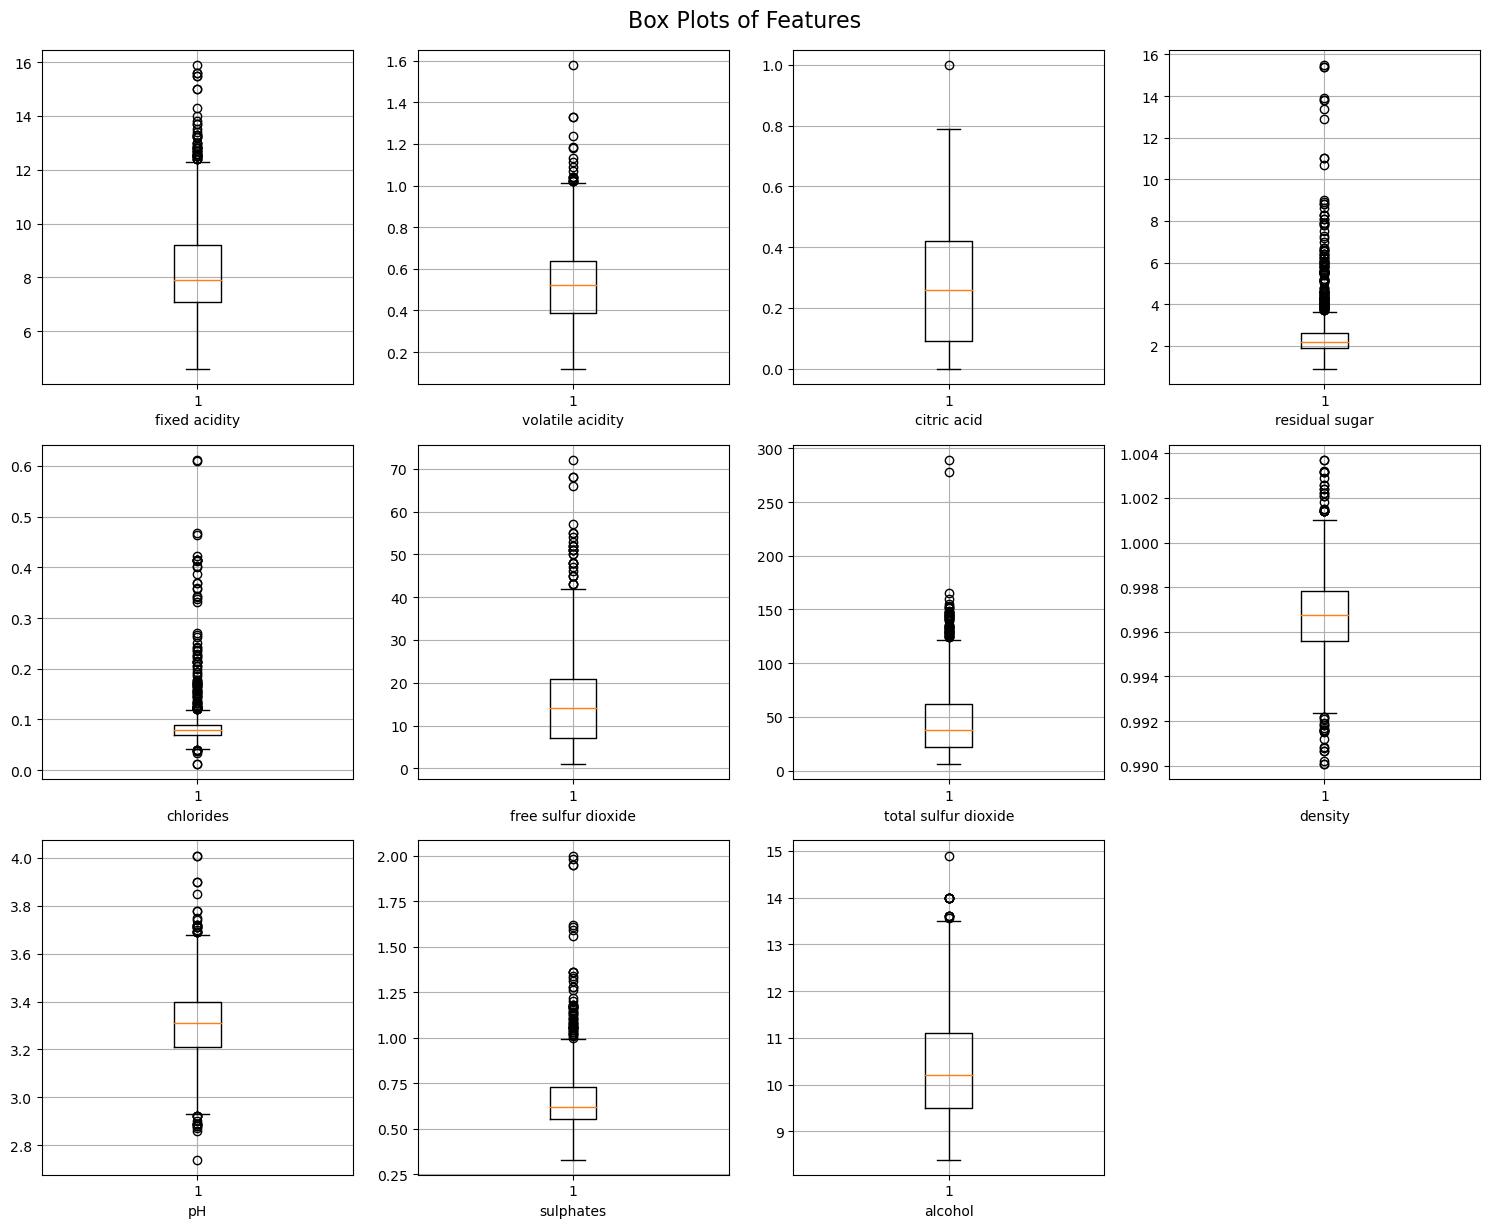

Ratio of not good to good wines: 0.87


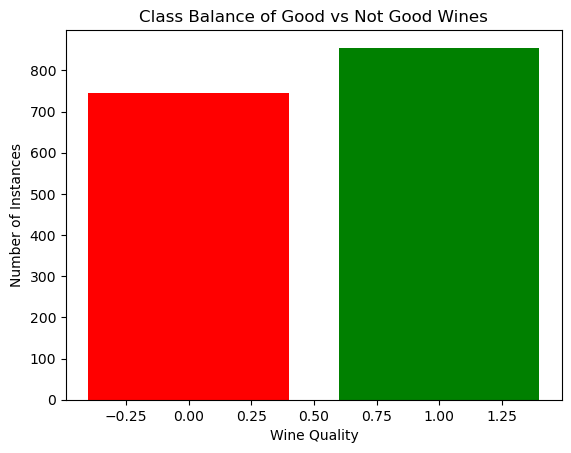

In [84]:
#Read in the dataset
data = pd.read_csv('winequality-red.csv')

# Add a 'label' column to the dataset
data['label'] = [1 if quality >= 6 else 0 for quality in data['quality']]

# List of feature columns (excluding 'quality' and 'label')
feature_columns = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
                   'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

# Generate a histogram of each feature to examine the scales
data[feature_columns].hist(figsize=(18, 10), bins=20)
plt.suptitle("Histograms of Each Feature")
plt.show()

# Create a figure for subplots
plt.figure(figsize=(12, 10))

# Create scatterplots of each predictor variable against the quality response variable in a compact manner
for index, feature in enumerate(feature_columns):
    plt.subplot(3, 4, index + 1) # 3 rows, 4 columns, current index + 1
    plt.scatter(data[feature], data['quality'], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('Quality')
    plt.title(f'{feature} vs Quality')
    plt.grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.suptitle("Scatter Plots of Features vs Quality", fontsize=16, y=1.02)
plt.show()

# Create a figure for subplots
plt.figure(figsize=(15, 12))

# Create boxplots of each feature to examine for outliers in a compact manner
for index, feature in enumerate(feature_columns):
    plt.subplot(3, 4, index + 1) # 3 rows, 4 columns, current index + 1
    plt.boxplot(data[feature])
    plt.xlabel(feature)
    plt.grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.suptitle("Box Plots of Features", fontsize=16, y=1.02)
plt.show()

# Count the number of occurrences of each class
class_counts = data['label'].value_counts()

# Calculate and print the ratio of good to not good wines
ratio = class_counts[0] / class_counts[1]
print(f"Ratio of not good to good wines: {ratio:.2f}")

# Create a bar chart
plt.bar(class_counts.index, class_counts.values, color=['green', 'red'])
plt.xlabel('Wine Quality')
plt.ylabel('Number of Instances')
plt.title('Class Balance of Good vs Not Good Wines')
plt.show()

## EDA Summary 

Through the exploratory data analysis (EDA), we found several insights about the red wine dataset. Most of the predictor variables, except for density and pH, do not appear to be normally distributed; though, sulphates seem to be fairly close to a normal distribution. By examining the scatterplots and box plots, it's evident that outliers are present in the dataset. The features residual sugar, chlorides, density, and sulphates, in particular, contain a significant number of outliers. In terms of class distribution, there is a slight imbalance with a ratio of not good to good wines being 0.87. While this indicates an imbalance, it is not extremely skewed and should still be manageable for training a model.

Considering the EDA findings, we will press forward with a KNN approach, but it is important that we keep the data's characteristics in mind. Since KNN is a distance-based algorithm, it's sensitive to the scale of the features and the presence of outliers. We can use the StandardScaler in order to normalize the features. Below, we will also remove outliers from the dataset. We remove values above and below the IQR and recreate the boxplots: 

## Preprocessing (Outlier Removal)

Shape after IQR filtering: (1179, 13)


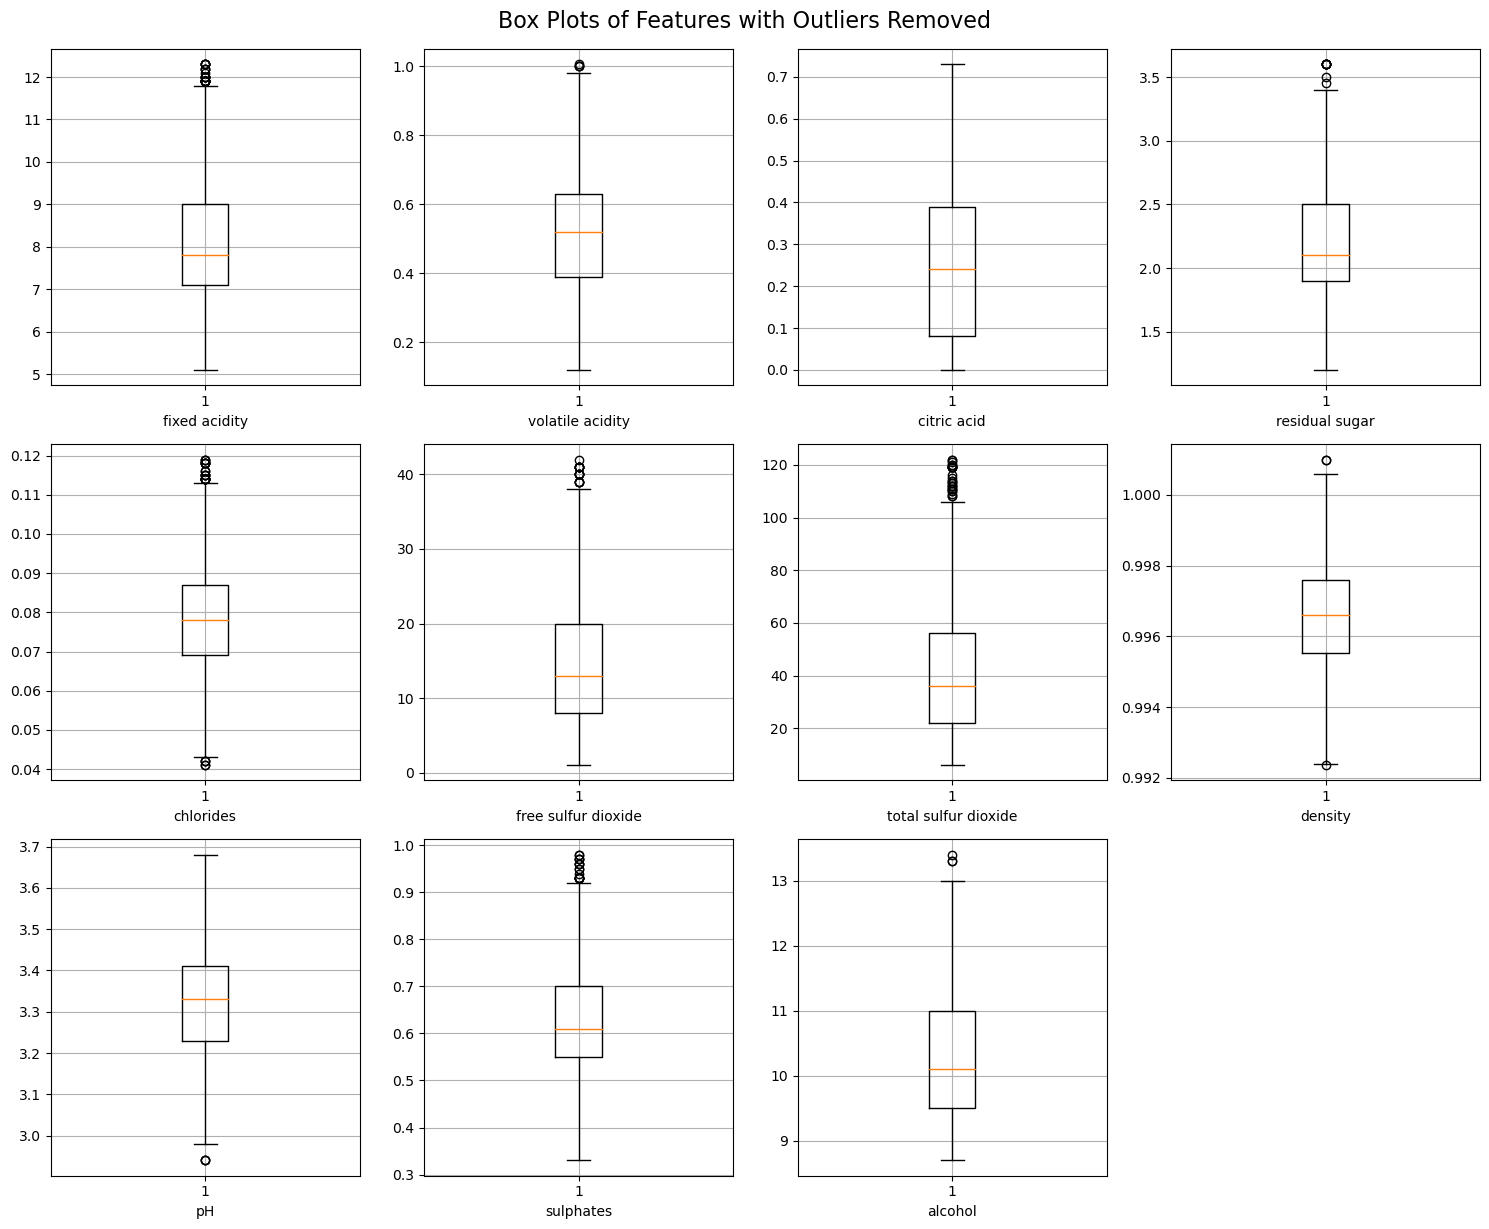

In [85]:
# Method 2: Interquartile Range (IQR) Method
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
data_iqr_filtered = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]
print("Shape after IQR filtering:", data_iqr_filtered.shape)

# Create a figure for subplots
plt.figure(figsize=(15, 12))

# Create boxplots of each feature to examine for outliers in a compact manner
for index, feature in enumerate(feature_columns):
    plt.subplot(3, 4, index + 1) # 3 rows, 4 columns, current index + 1
    plt.boxplot(data_iqr_filtered[feature])
    plt.xlabel(feature)
    plt.grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.suptitle("Box Plots of Features with Outliers Removed", fontsize=16, y=1.02)
plt.show()

We see much more reasonable boxplots with significantly less outliers for each variable. 

## KNN Approach

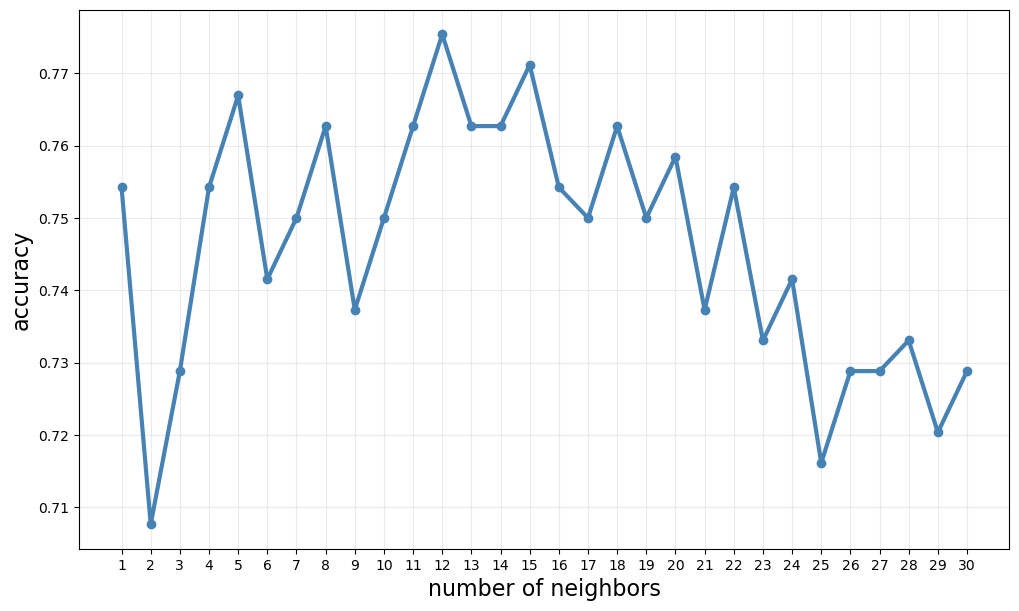

In [86]:
# Extract features and target variable
X = data_iqr_filtered.drop(columns=['quality', 'label'])
y = data_iqr_filtered['label']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Lists to store the values of K and corresponding accuracy scores
allks = list(range(1, 31))
acc = []

# Iteratively train KNN models for K = 1, 2, ..., 10
for k in allks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    predictions = knn.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    acc.append(accuracy)

# Create a plot of accuracy scores vs number of neighbors
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
ax.plot(allks, acc, marker="o", color="steelblue", lw=3, label="unweighted")
ax.set_xlabel("number of neighbors", fontsize=16)
ax.set_ylabel("accuracy", fontsize=16)
plt.xticks(range(1, 31))
ax.grid(alpha=0.25)
plt.show()

Above, we create a KNN model for values of K from 1 up to 30. We can see the greatest accuracy score lies at K = 12, the second highest being located at K = 15. The cell below prints out confusion matrices for each of these values, and also vizualizes the decision boundaries for these values of K on the first two features of the dataset (fixed acidity and volatile acidity - note that this is a simplified scenario for the sake of visualization and does not represent the full complexity of the dataset which has multiple features.

Confusion Matrix for k = 12:
[[85 26]
 [27 98]]
Confusion Matrix for k = 15:
[[ 79  32]
 [ 22 103]]


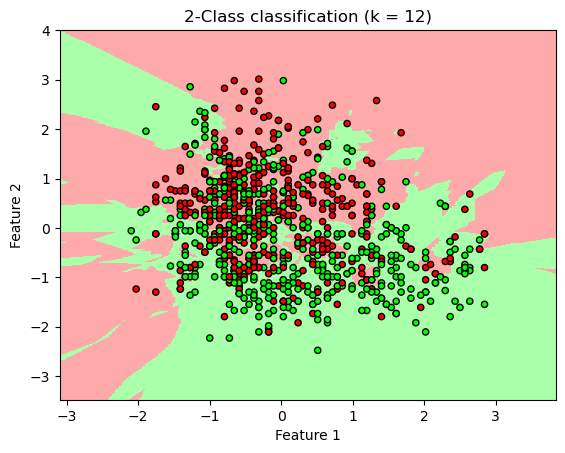

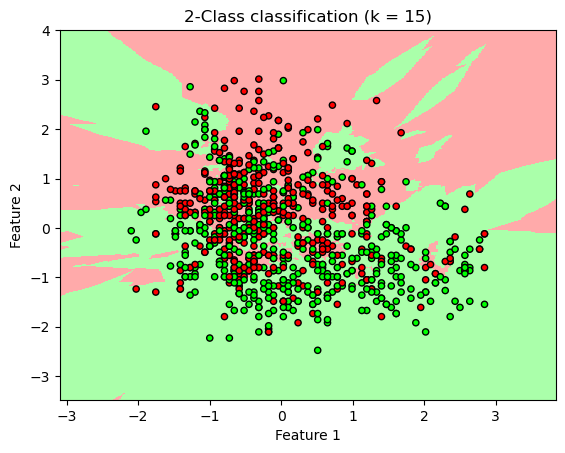

In [87]:
# k values to evaluate
k_values = [12, 15]

for k in k_values:
    # Train the KNN classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Predict the labels of the test set
    y_pred = knn.predict(X_test)
    
    # Print the confusion matrix
    print(f"Confusion Matrix for k = {k}:")
    print(confusion_matrix(y_test, y_pred))

# For visualizing decision boundaries, select only two features
X_train_2_features = X_train[:, :2]
X_test_2_features = X_test[:, :2]

# Mesh step size
h = .02

# Color map
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

# Loop over the k_values to plot decision boundaries
for k in k_values:
    # Train the KNN classifier with 2 features
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_2_features, y_train)

    # Plot the decision boundary
    x_min, x_max = X_train_2_features[:, 0].min() - 1, X_train_2_features[:, 0].max() + 1
    y_min, y_max = X_train_2_features[:, 1].min() - 1, X_train_2_features[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot the training points
    plt.scatter(X_train_2_features[:, 0], X_train_2_features[:, 1], c=y_train, cmap=cmap_bold, edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"2-Class classification (k = {k})")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

plt.show()

We can interpret the confusion matrices as follows: 

For k = 12:

- True Positive (TP) = 98: The number of wines that were correctly classified as 'good'.
- True Negative (TN) = 85: The number of wines that were correctly classified as 'not good'.
- False Positive (FP) = 26: The number of wines that were incorrectly classified as 'good' when they are actually 'not good'.
- False Negative (FN) = 27: The number of wines that were incorrectly classified as 'not good' when they are actually 'good'.

For k = 15:

- True Positive (TP) = 103: The number of wines that were correctly classified as 'good'.
- True Negative (TN) = 79: The number of wines that were correctly classified as 'not good'.
- False Positive (FP) = 32: The number of wines that were incorrectly classified as 'good' when they are actually 'not good'.
- False Negative (FN) = 22: The number of wines that were incorrectly classified as 'not good' when they are actually 'good'.

When comparing the two matrices, we see that by increasing k from 12 to 15, the number of True Positives has increased, which is good, but also the number of False Positives has increased, which is not desirable. True Negatives have decreased, and False Negatives have decreased.

There is a trade-off that needs to be considered. Depending on the problem context, it might be more important to accurately identify the 'good' class or vice versa. If it's more critical not to miss any good wines, we may favor the model with k = 15 as it has more True Positives and fewer False Negatives. However, if we want to be more conservative about not falsely labeling a wine as good, k = 12 might be a better choice. 

Considering that k = 12 is also more accurate overall, this is likely the appropriate choice. 